# Détection d'anomalies - Apprentissage non supervisé

In [1]:
from google.colab import files
uploaded = files.upload()

Saving creditcard.csv to creditcard.csv


In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, make_scorer, recall_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import OneClassSVM


In [3]:
import io
 
df = pd.read_csv(io.BytesIO(uploaded['creditcard.csv']))
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
df.isna().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

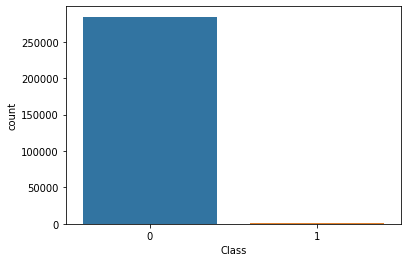

In [5]:
sns.countplot(x = 'Class', data = df);

In [6]:
df['Class'].value_counts(normalize = True)

0    0.998273
1    0.001727
Name: Class, dtype: float64

Variable cible hautement déséquilibrée

In [7]:
# Label -1 pour les outliers
df['Class'].replace({1 : -1, 0 : 1}, inplace = True)

In [8]:
X = df.drop('Class', axis = 1)
y = df['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

**Isolation Forest**

In [9]:
isof = IsolationForest(contamination = 0.001727, n_estimators = 100, n_jobs = -1)
isof.fit(X_train)

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


IsolationForest(contamination=0.001727, n_jobs=-1)

In [10]:
y_pred = isof.predict(X_test)
pd.crosstab(y_test, y_pred)

col_0,-1,1
Class,,
-1,26,73
1,83,56780


In [11]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.24      0.26      0.25        99
           1       1.00      1.00      1.00     56863

    accuracy                           1.00     56962
   macro avg       0.62      0.63      0.62     56962
weighted avg       1.00      1.00      1.00     56962



On va tenter d'améliorer le rappel en faisant une validation croisée

**StratifiedKFold et GridSearchCV**

In [12]:
# On découpe manuellement l'échantillon d'apprentissage
skf = StratifiedKFold(n_splits = 3)
folds = list(skf.split(X_train, y_train))
forest = IsolationForest()

In [13]:
resc = make_scorer(recall_score, pos_label = -1)
params = {'contamination' : np.linspace(0.001, 0.005, 10), 'n_estimators' : [100, 200, 300]}
search = GridSearchCV(estimator = forest, param_grid = params, scoring = resc, cv = folds, n_jobs = -1)
search.fit(X_train, y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


GridSearchCV(cv=[(array([ 74181,  74879,  74946, ..., 227842, 227843, 227844]),
                  array([    0,     1,     2, ..., 75952, 75953, 75954])),
                 (array([     0,      1,      2, ..., 227842, 227843, 227844]),
                  array([ 74181,  74879,  74946, ..., 159890, 160021, 160160])),
                 (array([     0,      1,      2, ..., 159890, 160021, 160160]),
                  array([151878, 151879, 151880, ..., 227842, 227843, 227844]))],
             estimator=IsolationForest(), n_jobs=-1,
             param_grid={'contamination': array([0.001     , 0.00144444, 0.00188889, 0.00233333, 0.00277778,
       0.00322222, 0.00366667, 0.00411111, 0.00455556, 0.005     ]),
                         'n_estimators': [100, 200, 300]},
             scoring=make_scorer(recall_score, pos_label=-1))

In [14]:
optimal_forest = search.best_estimator_
y_pred2 = optimal_forest.predict(X_test)
pd.crosstab(y_test, y_pred2)

col_0,-1,1
Class,,
-1,48,51
1,257,56606


In [15]:
print(classification_report(y_test, y_pred2))

              precision    recall  f1-score   support

          -1       0.16      0.48      0.24        99
           1       1.00      1.00      1.00     56863

    accuracy                           0.99     56962
   macro avg       0.58      0.74      0.62     56962
weighted avg       1.00      0.99      1.00     56962



**One Class SVM**

In [16]:
# On sélectionne les labels qui valent 1
y_inliers = y_train[y_train.values == 1]
# Liste d'index pour récupérer les variables
liste = list(y_inliers.index.values)
# On récupère ces variables dans un nouveau dataframe
X_train_inliers = X_train.loc[liste]

In [17]:
# Normalisation des données
scaler = MinMaxScaler(feature_range = (-1, 1)).fit(X_train_inliers)
X_train_inliers = scaler.transform(X_train_inliers)
X_test = scaler.transform(X_test)

In [18]:
osvm = OneClassSVM(kernel = 'rbf', nu = 0.005, gamma = 'scale')
osvm.fit(X_train_inliers)

OneClassSVM(nu=0.005)

In [19]:
y_pred3 = osvm.predict(X_test)
pd.crosstab(y_test, y_pred3)

col_0,-1,1
Class,,
-1,58,41
1,313,56550


In [20]:
print(classification_report(y_test, y_pred3))

              precision    recall  f1-score   support

          -1       0.16      0.59      0.25        99
           1       1.00      0.99      1.00     56863

    accuracy                           0.99     56962
   macro avg       0.58      0.79      0.62     56962
weighted avg       1.00      0.99      1.00     56962

